---
title: "A better understanding of PyMC objects using linear regression"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

In [a previous post](https://benslack19.github.io/data%20science/statistics/pymc-linreg-entry01/), I wrote about my inital experience using [PyMC3](https://docs.pymc.io/). The point was to take a dive deep into some of the package's objects using a linear regression problem using PyMC3. Here, I'll go a little bit further and interpre the posterior distribution. Some of the initial code are replicated from the previous post to save steps.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

Here again is the question.

**The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.**

| Individual | weight | expected height | 89% interval |
| ------ | ------ | -------- | ---------- |
| 1|  45  |  |
| 2 | 40 |  |  |
| 3 | 65 | |  |
|4  | 31  |  |  |

In [4]:
d = pd.read_csv("../data/a_input/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]  # filter to get only adults

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='weight', ylabel='height'>

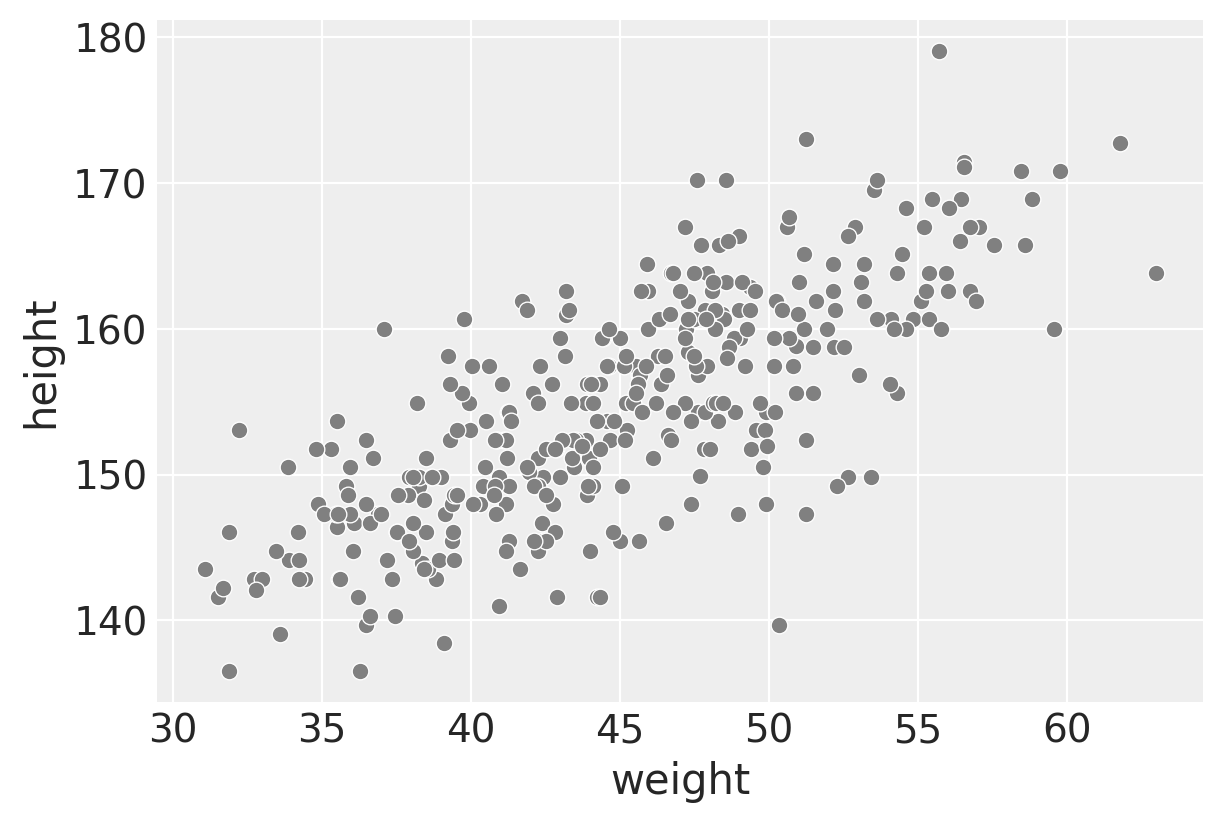

<IPython.core.display.Javascript object>

In [5]:
f, ax1 = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=d2, x="weight", y="height", color="gray")

We'd expect a linear relationship between `weight` and `height` in the adult population and that's what we see here.

# Setting up the variables, producing `model ` and `trace` objects

In [6]:
# Get the average weight as part of the model definition
xbar = d2.weight.mean()

<IPython.core.display.Javascript object>

In [7]:
with pm.Model() as heights_model:

    # Priors are variables a, b, sigma
    # using pm.Normal is a way to represent the stochastic relationship the left has to right side of equation
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (d2.weight, which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * (d2.weight - xbar)

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

    # The next lines is doing the fitting and sampling all at once.
    # I'll use the return_inferencedata=False flag
    trace_m2 = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In the last post, I looked to understand the model objects, but here I'll go straight to interpretation. But a reminder that `trace_m2` is a `MultiTrace` object that is outputted as a result of setting `return_inferencedata=False` in the `pm.sample()` call. (It's the same object that is outputted in the PyMC3 repo of the book's code which is why I decided to work with it here.)

The trace object contains the samples collected, in the order they were collected per the PyMC3's. [getting started tutorial](https://docs.pymc.io/notebooks/getting_started.html).  It is much clearer to see this concretely when we use the `trace_to_dataframe` function.

In [8]:
trace_m2_df = pm.trace_to_dataframe(trace_m2)
trace_m2_df

,a,b,sigma
0,154.030585,0.853788,4.989442
1,153.969973,0.861619,5.128790
2,155.111070,0.957769,5.067568
3,154.106523,0.838728,4.961068
4,154.328210,0.863311,5.160797
...,...,...,...
3995,154.527044,0.875573,4.883293
3996,154.508437,0.913224,5.001473
3997,154.860021,0.866046,5.089966
3998,154.285508,0.932101,5.019234


<IPython.core.display.Javascript object>

Why are there 4000 rows? It can be explained by looking at some of the earlier code and the output.

This was in the initial model fitting:
<br>
`trace_m = pm.sample(1000, tune=1000)`
<br>
`Multiprocess sampling (4 chains in 4 jobs)`

I don't know how to take into account this multiprocess sampling, so I'll treat the 4000 rows as simply being different samples drawn from the posterior distribution. More explanation is shown [here](https://stackoverflow.com/questions/61969968/understanding-the-parameters-of-pymc3-package).

As you can see, each row is a different instantiation of alpha, beta, and sigma values. Each row is a different "*i*th" set of values that is in these equations.

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta(x_i  - \bar{x})$

# Interpreting the posterior distribution

Per McElreath's text:
> Interpretation can be helped by generating tables and making plots of simulated data. The latter will be more helpful to know:
> 1. Whether the model fit procedure worked correctly
> 2. Gaining a sense for whether the absolute magnitude, and not just the relative magnitude, of a relationship between outcome and predictor.
> 3. The uncertainty surrounding an average relationship
> 4. The uncertainty surrounding the implied predictions of the model, as there are distinct from mere parameter uncertainty

## Tables of marginal distributions

The tables here look like summary statistics but the term "marginal" here refers to “averaging over the other parameters.” We can get some helpful summaries for $\alpha, \beta$, and $\sigma$ to help with model inspection.

Point estimates are not the most useful ultimately, but here is how to return the *maximum a posteri* estimates for the model.

In [9]:
pm.find_MAP(model=heights_model)

{'a': array(154.60136748),
 'b_log__': array(-0.10172172),
 'sigma_interval__': array(-2.18135226),
 'b': array(0.90328088),
 'sigma': array(5.07188029)}

<IPython.core.display.Javascript object>

The next set of code gives both the MAP as well as providing a sense of the variance of the data, which is more useful.

In [11]:
# az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
az.summary(trace_m2, round_to=3, kind="stats")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,154.600,0.275,154.178,155.055
b,0.903,0.043,0.835,0.970
sigma,5.103,0.195,4.789,5.404


<IPython.core.display.Javascript object>

 (Note that inputting the object `trace_m1` where `return_inferencedata=True` will return the data without a warning.)

The following is a way to get the covariances among the parameters (variance-covariance matrix).

In [13]:
trace_m2_df.cov().round(3)

,a,b,sigma
a,0.075,0.000,0.000
b,0.000,0.002,-0.000
sigma,0.000,-0.000,0.038


<IPython.core.display.Javascript object>

The other way of looking at it this variance-covariance matrix is to break it down into two elements:
1. A vector of variances for the parameters.
2. A correlation matrix that tells how changes in any parameter lead to correlated changes in the others.

In [14]:
# The vector of variances for the parameters
# Note how the function call is reflected in the numbers above
print("Variances of parameters: ", np.diag(trace_m2_df.cov()))

Variances of parameters:  [0.07542452 0.00185532 0.03783937]


<IPython.core.display.Javascript object>

These are a vector of variances so taking the square root for each will give the same standard deviations in the `az.summary` call above.

In [15]:
# Get the standard deviations back
print("Standard deviations of parameters: ", np.sqrt(np.diag(trace_m2_df.cov())))

Standard deviations of parameters:  [0.27463525 0.04307342 0.19452344]


<IPython.core.display.Javascript object>

The correlation matrix can show how changing one parameter affects another.

In [16]:
trace_m2_df.corr()

,a,b,sigma
a,1.000000,0.027097,0.002509
b,0.027097,1.000000,-0.014563
sigma,0.002509,-0.014563,1.000000


<IPython.core.display.Javascript object>

Like in the book: "Very little covariation among the parameters in this case. Using pairs(m4.3) shows both the marginal posteriors and the covariance. In the practice problems at the end of the chapter, you’ll see that the lack of covariance among the parameters results from CENTERING."

## Visualizing the prior and posterior distributions of parameters

Plotting can be very helpful for model diagnostics. I started off plotting some things with `seaborn` and `scipy.stats` functions, but then used some `arviz` functions that are built for these kinds of data.

Let's visualize at the prior and posterior distributions of our parameters. I'm using the `scipy.stats` normal, lognormal, and uniform distributions for alpha, beta, and sigma prior distributions. (They each have a vector length of 4000 to match the posterior's length, but this is arbitrary. I'm using the `trace_m2` object's returned parameters for the posterior.

<ipython-input-17-9fe321eccdfc>:40: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


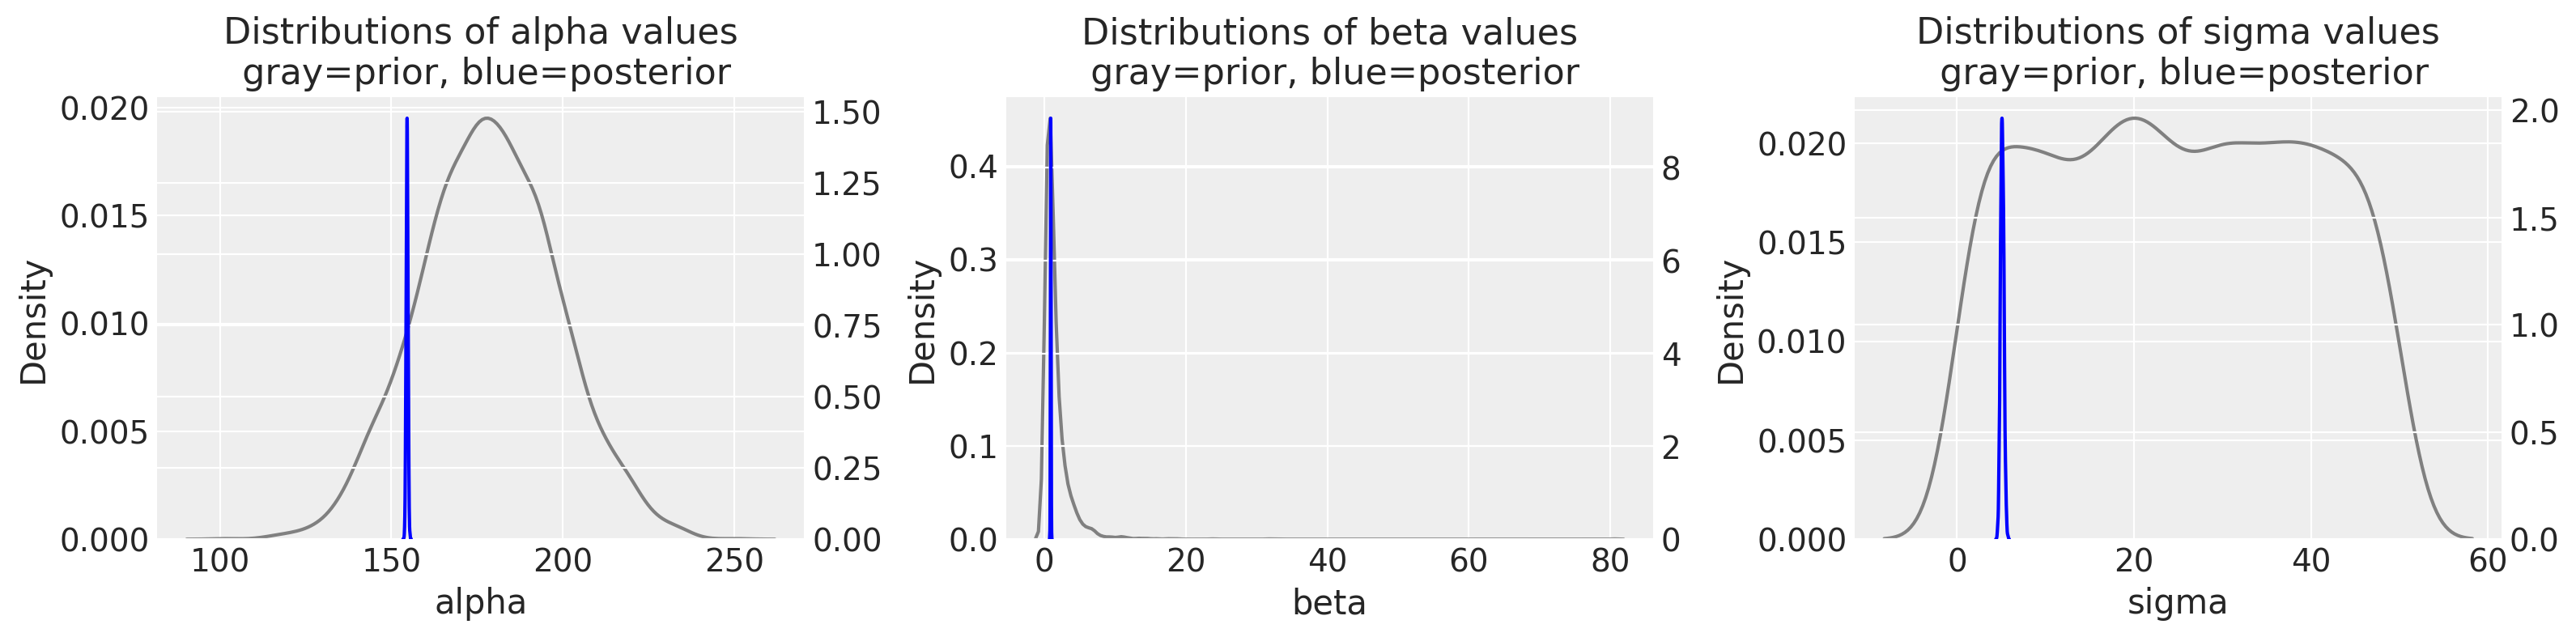

<IPython.core.display.Javascript object>

In [17]:
f, (ax1, ax3, ax5) = plt.subplots(1, 3, figsize=(16, 4))

sns.kdeplot(
    stats.norm.rvs(loc=178, scale=20, size=4000),
    alpha=0.5,
    color="gray",
    ax=ax1,
)
ax2 = ax1.twinx()
sns.kdeplot(trace_m2_df["a"], alpha=0.5, color="blue", ax=ax2)
ax1.set_xlabel("alpha")
ax2.set_ylabel("")
ax1.set_title("Distributions of alpha values\n gray=prior, blue=posterior")


sns.kdeplot(
    stats.lognorm.rvs(s=0.954, loc=0, scale=1, size=4000),
    alpha=0.5,
    color="gray",
    ax=ax3,
)
ax4 = ax3.twinx()
sns.kdeplot(trace_m2_df["b"], alpha=0.5, color="blue", ax=ax4)
ax3.set_xlabel("beta")
ax4.set_ylabel("")
ax3.set_title("Distributions of beta values\n gray=prior, blue=posterior")

sns.kdeplot(
    stats.uniform.rvs(loc=0, scale=50, size=4000),
    alpha=0.5,
    color="gray",
    ax=ax5,
)
ax6 = ax5.twinx()
sns.kdeplot(trace_m2_df["sigma"], alpha=0.5, color="blue", ax=ax6)
ax5.set_xlabel("sigma")
ax6.set_ylabel("")
ax5.set_title("Distributions of sigma values\n gray=prior, blue=posterior")

plt.tight_layout()

The difference between gray and blue plots are so striking; for each variable, we are going from a pretty wide distribution in the priors to a really narrow distribution in the posterior. You can also appreciate this when comparing the probability density values between the left (prior) and right (posterior) y-axes.

Here is a fast way to visualize the posterior values with `arviz`.

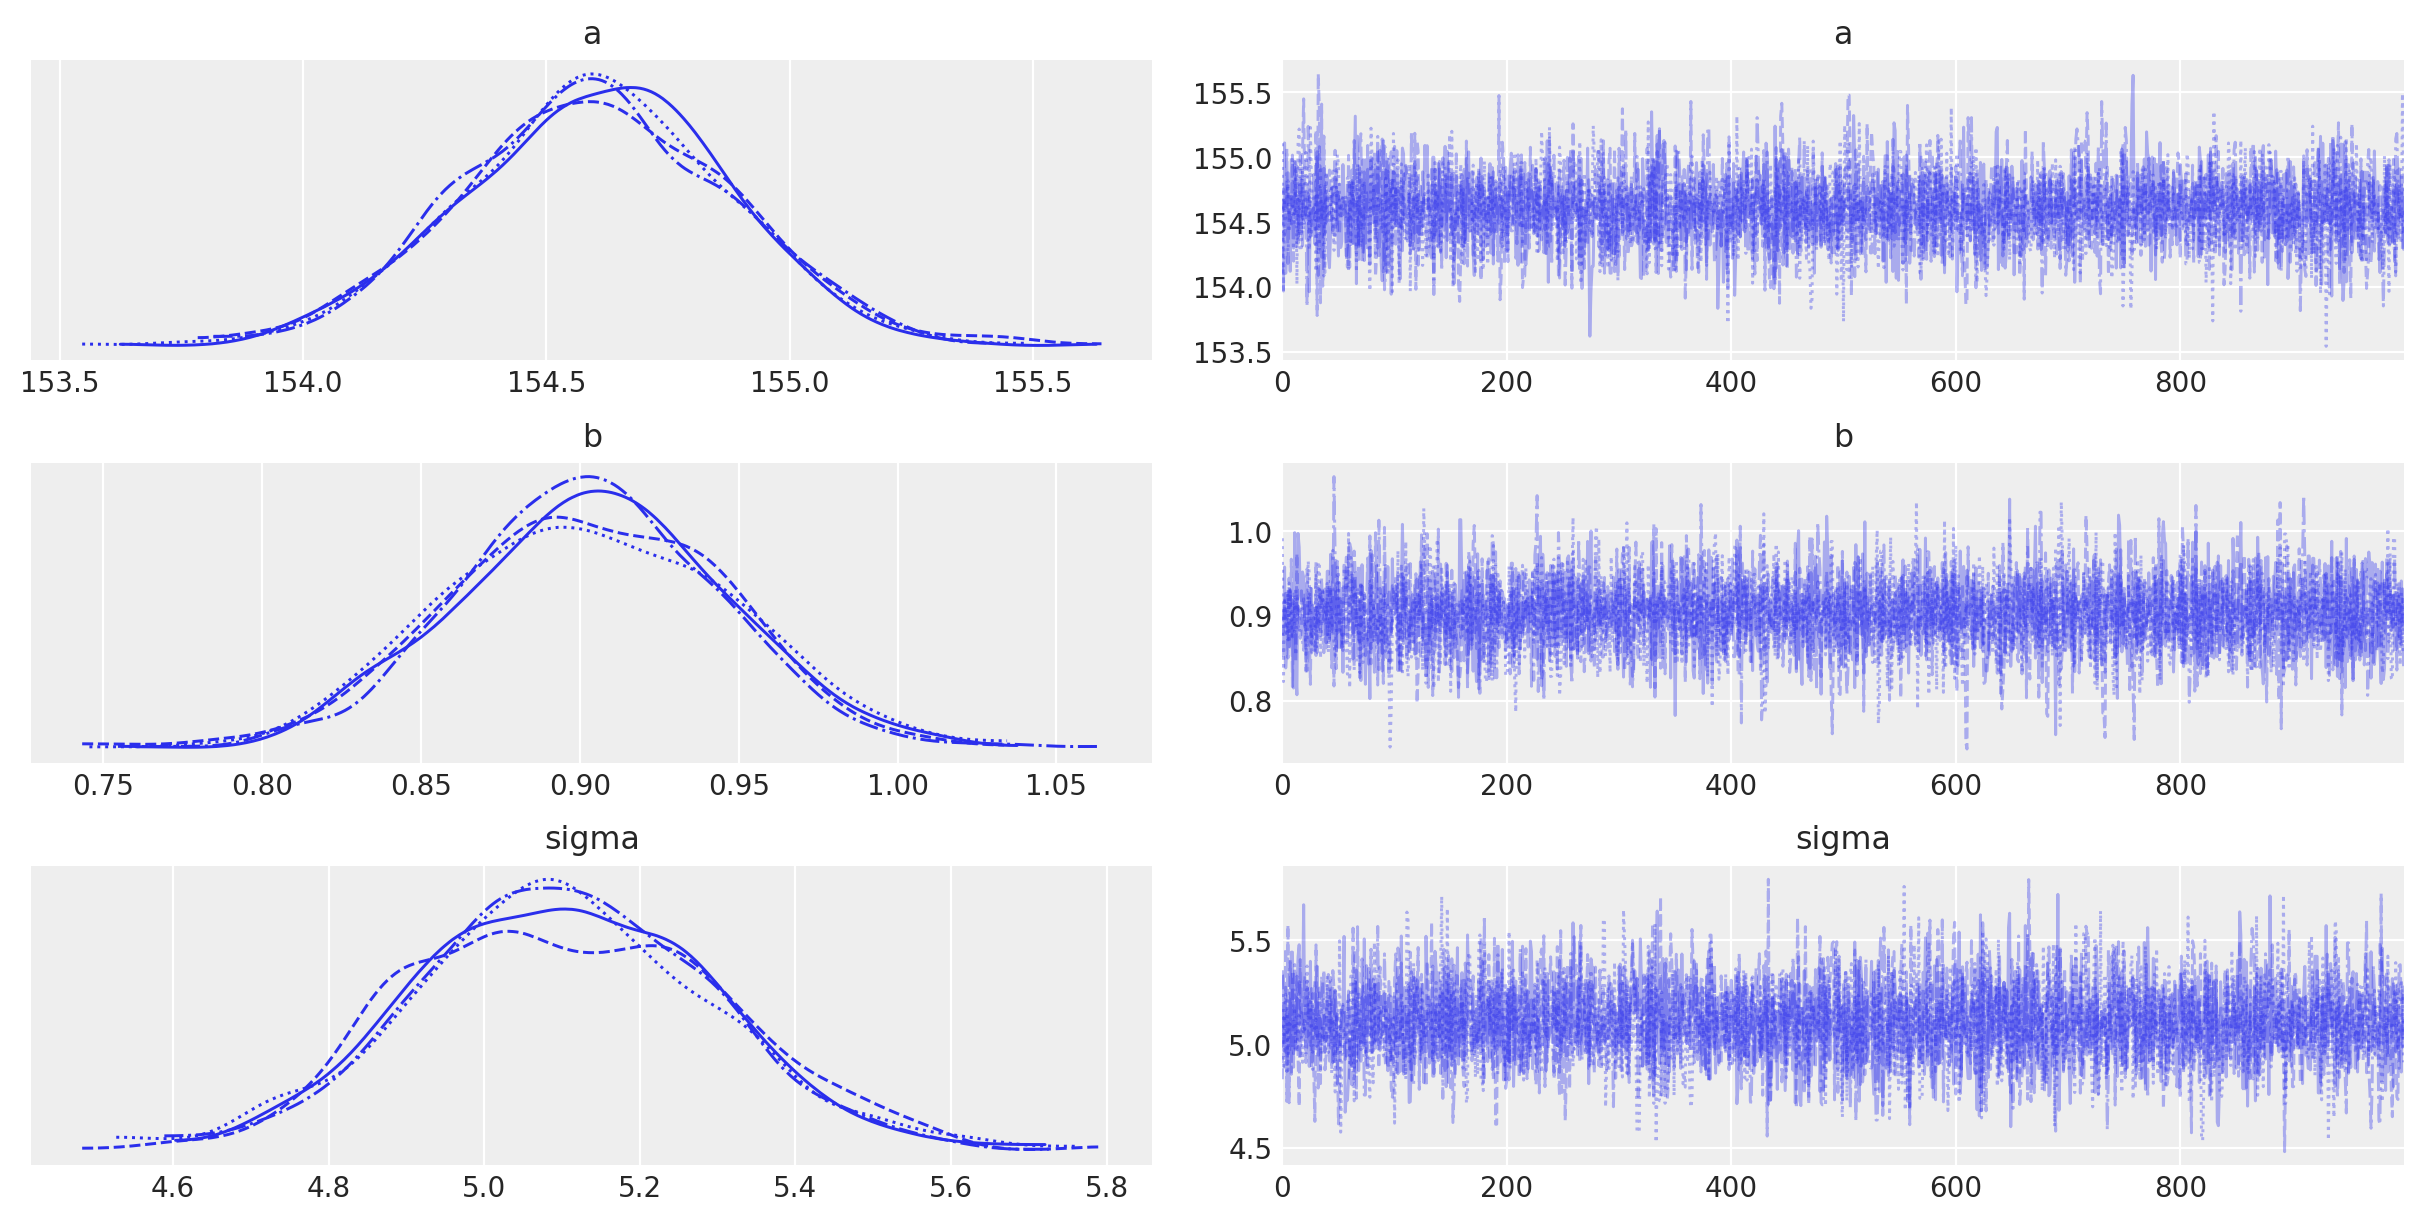

<IPython.core.display.Javascript object>

In [18]:
with heights_model:
    az.plot_trace(trace_m2)

Per the PyMC documentation: "The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients."

# Summary

The purpose of this post is to use `pymc` to go from the fitting procedure to obtaining posterior distributions of our parameters. We can now see how our possible parameter values have been constrained after we factor in the data. In the next post, we will use the posterior distribution to make predictions.

# Appendix: Environment and system parameters

In [19]:
%watermark -n -u -v -iv -w

Last updated: Sun May 09 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
arviz     : 0.11.1
pymc3     : 3.11.0
scipy     : 1.6.0
numpy     : 1.20.1
json      : 2.0.9
seaborn   : 0.11.1
matplotlib: 3.3.4

Watermark: 2.1.0



<IPython.core.display.Javascript object>